In [1]:
%load_ext autoreload
%autoreload 2
import sys
if '..' not in sys.path: sys.path.append("..")

# Segmentation and boundary-box regression

TODO: 
* Load model
* Plot intensity distribution
* Evaluate a good threshold (Weakly Supervised Deep Learning for Segmentationof Remote Sensing Imagery)

Some help:
https://stackoverflow.com/questions/64617205/merging-each-instance-mask-back-to-the-original-image-python
https://stackoverflow.com/questions/61383095/create-mask-or-boundary-from-each-other-in-python3

In [230]:
from src.segmentation.roi import RoIAlign
from src.utils.preprocess import tensor2numpy, image2axial,mask_threshold
from src.segmentation import cam
from src.classifier.agent import load_trainer
import nibabel as nib
from src.segmentation.cam import CAMS
import numpy as np
import torchvision
import torch
import matplotlib.pyplot as plt

In [3]:
trainer, dataset, model = load_trainer('resnet50', checkpoint_path="/logs/tb/resnet50/version_7/checkpoints/checkpoint-v1.ckpt");

Loading model from /home/stud1/f/fremar16/Master_thesis/logs/tb/resnet50/version_7/checkpoints/checkpoint-v1.ckpt (checkpoint)..
Architecture [ResNet] was created
***Defined hyperparameters:***
"arch":                {'name': 'resnet50', 'args': {}}
"callbacks":           ['litprogressbar', 'modelcheckpoints', 'metriccallback']
"class_weights":       None
"hp_metrics":          ['loss/train', 'loss/val', 'accuracy/val', 'auc/val', 'specificity/val', 'sensitivity/val']
"kfold":               {'enable': False, 'folds': 10}
"loss":                CrossEntropyLoss
"loss_weight_balance": None
"optimizer":           {'type': 'Adam', 'args': {'lr': 0.0002, 'weight_decay': 1e-05, 'amsgrad': False}}
Dataset sizes - Training: 421 Validation: 47


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Using native 16bit precision.


In [4]:
tmp_image = nib.load('../data/SPM_categorised/AIH/AD/AD_ADNI_2491.nii').get_fdata()
tmp = cam.CAM(CAMS.SmoothGradCAMpp.value, model, image2axial(tmp_image))

grid_image, grid_mask = tmp.grid_class(tmp.class_scores, 2, pad_value=0, max_num_slices=None)

3


/home/stud/f/fremar16/miniconda3/envs/Master-thesis/lib/python3.9/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


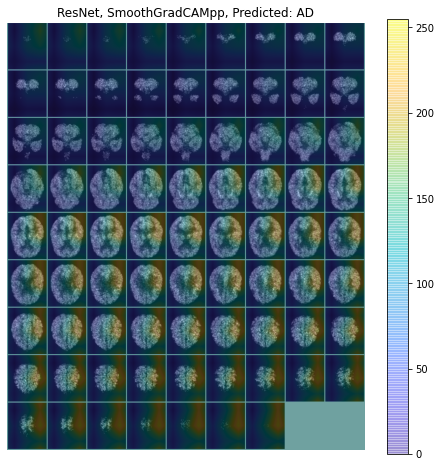

In [5]:
tmp.plot(tmp.class_scores, 2,max_num_slices=None);

## Functions

In [234]:
from skimage import exposure, filters, measure
from scipy import ndimage
import matplotlib.patches as mpatches

def intensity_distribution(image, title=""):
    b, bins, patches = plt.hist(image, 255)
    # Ignore the first value as it is only zeros
    _, counts = np.unique(image, return_counts=True)
    plt.xlim([0,255])
    plt.ylim([0,counts[1:].max()])
    plt.title(title)
    plt.show()
    

def mask_mean_filter(mask:np.ndarray) -> np.ndarray:
    """Apply a mean filter of size (7,7,7) on the 3D image"""
    mean_mask = ndimage.median_filter(mask, size=(7,7,7))
    
    return mean_mask

def mask_logarithmic_scale(mask:np.ndarray) -> np.ndarray:
    """Convert mask to logarithmic scale"""
    logarithmic_corrected = exposure.adjust_log(sliced_masks, 1)
    
    return logarithmic_corrected

def mask_clipping(mask:np.ndarray) -> np.ndarray:
    vmin, vmax = np.percentile(mask, q=(20, 99.5))

    clipped_data = exposure.rescale_intensity(
        mask,
        in_range=(vmin, vmax),
        out_range=np.float32
    )
    return clipped_data

def display(im3d:np.ndarray, cmap:str="jet", step:int=2, plottype:str='imshow'):
    """Plot 3D image as 2D slices"""
    
    ncols = 9
    nrows = 1 if im3d.shape[0]//(ncols*step) == 0 else im3d.shape[0]//(ncols*step)
    
    _, axes = plt.subplots(nrows=nrows, ncols=9, figsize=(10, 1*nrows))

    vmin = im3d.min()
    vmax = im3d.max()
    
    for ax, image in zip(axes.flatten(), im3d[::step]):
        if plottype == 'imshow':
            ax.imshow(image, cmap=cmap, vmin=vmin, vmax=vmax)
        elif plottype == 'hist':
            ax.hist(image.ravel(), bins=255, histtype='step', color='black');
            
        ax.set_xticks([])
        ax.set_yticks([])
        
def remove_known_background_from_mask(image:np.ndarray, image_mask:np.ndarray) -> np.ndarray:
    """We know that background cant be useful activations. Remove them"""
    im = image_mask.copy() 
    im[~(image > 0)] = image_mask.min()
    return im

def check_join_segmentations(mask_one:np.ndarray, mask_two:np.ndarray) -> np.ndarray:
    """Observe the intersection of two masks"""
    from skimage.segmentation import join_segmentations
    return join_segmentations(mask_one, mask_two)

def segment_mask(image_mask:np.ndarray) -> np.ndarray:
    """Simple segmentation of the mask input
    Note: This one might need some scientific rework since it is not very good
    """
    n=32
    im = filters.gaussian(sliced_masks, sigma=1/(4.*n), mode='nearest')
    mask = im > im.max()*0.6
    label_im, nb_labels = ndimage.label(mask)
    return label_im

def extract_features(image_mask:np.ndarray, image:np.ndarray):
    """Create objects of each slice where the selected regions are extrac"""
    features = []
    for mask, image in zip(image_mask, image):
        props = measure.regionprops(mask, image)  # only one object
        features.append(props)
    return features

def bounding_boxes(features):
    """Expects features from 2D images
    
    Return:
        * List of tuples: Tuple[D, Y0,X0,Y1,X1]
    """
    boxes = []
    
    # Features must exist!
    for slice_idx, feature in enumerate(features):

        # For each bounding box:
        for r in feature:
            minr, minc, maxr, maxc = r.bbox
            boxes.append((slice_idx, minr, minc, maxr, maxc))
    return boxes

def plot_features_regions(features:list, image_mask:np.ndarray,step=1):
    """Plot the extracted features"""
    ncols = 9
    nrows = 1 if len(image_mask) == 0 else len(image_mask)//ncols
    _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 1*nrows))

    vmin = image_mask.min()
    vmax = image_mask.max()

    for ax, image, feature in zip(axes.flatten(), image_mask[::step], features):
        ax.imshow(image, cmap='jet', vmin=vmin, vmax=vmax)
 
        for r in feature:
            minr, minc, maxr, maxc = r.bbox
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)

            ax.plot(*r.centroid[::-1], marker='x', color='r')

        ax.set_xticks([])
        ax.set_yticks([])

def roi_align(image, features):
    """ Create aligned image rois for the neural network
    Arg:
        * Image of shape Tuple[D,H,W]
        * List of features of shape List[Tuple[int,int,int,int,int]] 
    """
    image_tensor = torch.from_numpy(image).unsqueeze(1).float()
    boxes = torch.Tensor(bounding_boxes(features))
    
    roialign = RoIAlign(40,spatial_scale=1.0,sampling_ratio=-1)
    image_rois = roialign.forward(image_tensor,boxes)
    display(test.squeeze(1),step=1)
    
    return image_rois

def sequential_processing(image:np.ndarray, image_mask:np.ndarray) -> None:
    """Run each processing of mask to segmentation"""
    mask_mean = mask_logarithmic_scale(image_mask)
    segmented_mask = segment_mask(mask_mean)
    mask_no_background = remove_known_background_from_mask(image, segmented_mask)
    
    features = extract_features(mask_no_background, image_mask)
    plot_features_regions(features, mask_no_background)
    
    return features

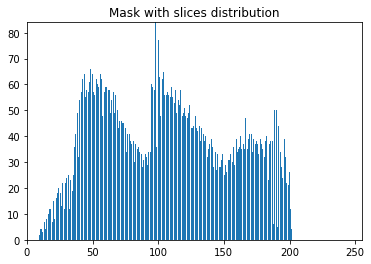

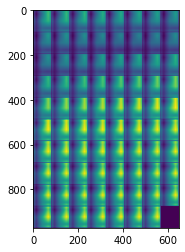

In [8]:
# Only check the distribution from each image! This looks a lot better!
intensity_distribution(tmp.preprocess(tmp.activation_map(tmp.class_idx, tmp.class_scores))[30].flatten(),title="Mask with slices distribution")

sliced_masks = tmp.preprocess(tmp.activation_map(0, tmp.class_scores))
plt.imshow(torchvision.utils.make_grid(torch.from_numpy(sliced_masks).unsqueeze(1), nrow=8)[0])

# Test with each slice

In [9]:
from skimage import exposure, io, util
from skimage import data, img_as_float
from skimage.morphology import disk
from skimage.filters import rank

## Test of thresholding

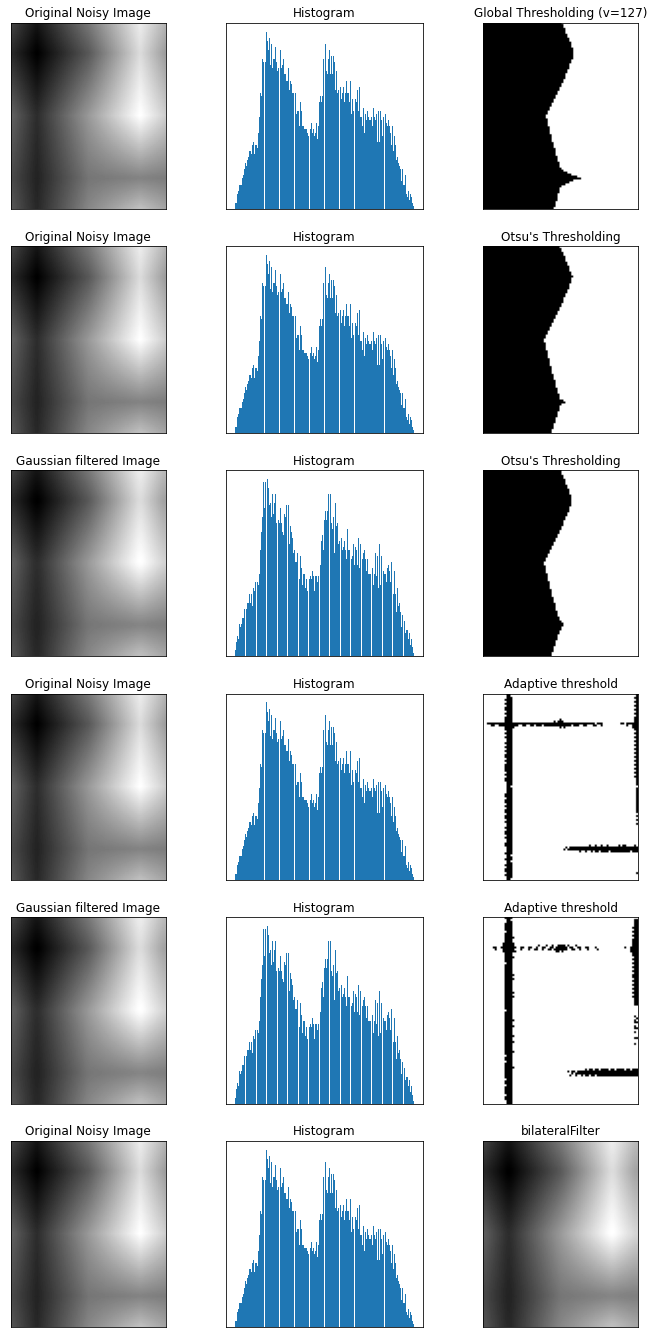

In [10]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

img = sliced_masks[50].copy()

# global thresholding
ret1,th1 = cv.threshold(img,127,255,cv.THRESH_BINARY)

# Otsu's thresholding
ret2,th2 = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

# Otsu's thresholding after Gaussian filtering
blur = cv.GaussianBlur(img,(5,5),0)
ret3,th3 = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

# Adaptive threshold
th4 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,11,2)

# Adaptive threshold after Gaussian filtering
th5 = cv.adaptiveThreshold(blur,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,11,2)

th6 = cv.bilateralFilter(img,5,100,100)
#th6 = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
# plot all the images and their histograms
images = [
    img, 0, th1,
    img, 0, th2,
    blur, 0, th3,
    img, 0, th4,
    blur, 0, th5,
    img, 0, th6,
]
titles = [
    'Original Noisy Image','Histogram','Global Thresholding (v=127)',
    'Original Noisy Image','Histogram',"Otsu's Thresholding",
    'Gaussian filtered Image','Histogram',"Otsu's Thresholding",
    'Original Noisy Image','Histogram',"Adaptive threshold",
    'Gaussian filtered Image','Histogram',"Adaptive threshold",
    'Original Noisy Image','Histogram',"bilateralFilter",
]
rows = len(images)//3
fig = plt.figure(figsize=(12,4*rows))

for i in range(rows):
    plt.subplot(rows,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    
    plt.subplot(rows,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    
    plt.subplot(rows,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

## Notes:
Otsu and global thresholding does not fix the problem.

# Test with SCIPY

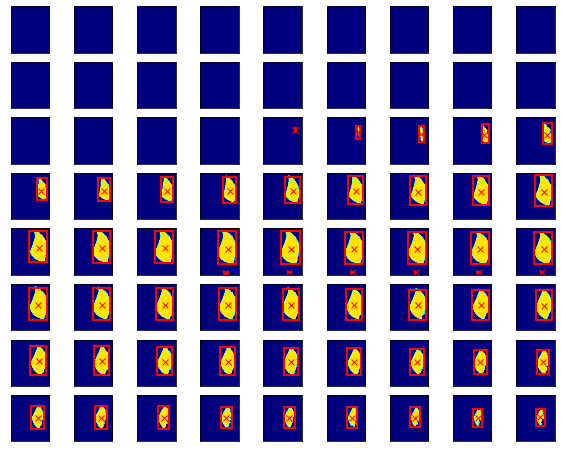

In [220]:
features = sequential_processing(tmp.image, sliced_masks)

# RoIAlign

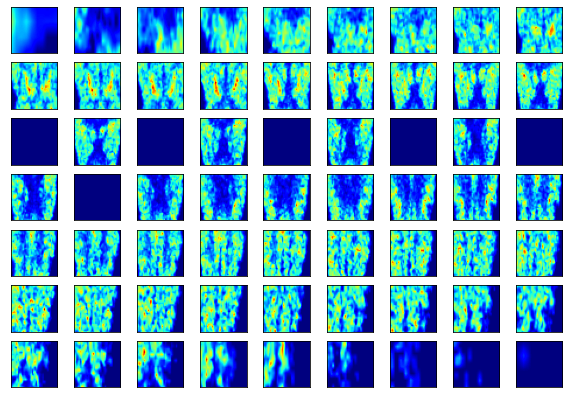

In [235]:
derp = roi_align(tmp.image, features)